In [2]:
# file kfkd.py
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle


FTRAIN = './training.csv'
FTEST = './test.csv'



def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

#     print(df.head())
#     print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
# print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
#     X.shape, X.min(), X.max()))
# print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
#     y.shape, y.min(), y.max()))

In [50]:
from lasagne import layers
import pickle
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

X, y = load()

net1.fit(X, y)
with open('net1.pickle', 'wb') as f:
    pickle.dump(net1, f, -1)

/Users/jionghaowu/anaconda/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/jionghaowu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.18084     0.03572    5.06222  0.27s
      2     0.02124     0.01527    1.39077  0.22s
      3     0.01486     0.01436    1.03461  0.22s
      4     0.01344     0.01297    1.03585  0.22s
      5     0.01237     0.01230    1.00641  0.24s
      6     0.01178     0.01180    0.99761  0.26s
      7     0.01130     0.01140    0.99124  0.28s
      8     0.01090     0.01105    0.98640  0.27s
      9     0.01057     0.01075    0.98237  0.27s
     10     0.01027     0.01049    0.97880  0.27s
     11     0.01001     0.01026    0.97576  0.27s
     12     0.00977     0.01004    0.97317  0.26s
     13     0.00956     0.00984    0.97100  0.27s
     14     0.00936     0.00966    0.96915  0.26s
     15     0.00918     0.00

In [12]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

NameError: name 'net1' is not defined

In [4]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()

NameError: name 'net1' is not defined

In [6]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [27]:
# import cPickle as pickle
import pickle
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=100,
    verbose=1,
    )

X, y = load2d()  # load 2-d data
net2.fit(X, y)

# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:

with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

/Users/jionghaowu/anaconda/lib/python3.6/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
/Users/jionghaowu/anaconda/lib/python3.6/site-packages/lasagne/layers/pool.py:240: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/Users/jionghaowu/anaconda/lib/python3.6/site-packages/lasagne/layers/pool.py:240: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/Users/jionghaowu/anaconda/lib/python3.6/site-packages/lasagne/layers/pool.py:240: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.10499     0.03343    3.14087  38.14s
      2     0.01724     0.00899    1.91825  37.64s
      3     0.00868     0.00743    1.16870  36.77s
      4     0.00735     0.00682    1.07822  36.69s
      5     0.00689     0.00645    1.06909  36.31s
      6     0.00656     0.00615    1.06682  36.74s
      7     0.00629     0.00590    1.06628  35.93s
      8     0.00606     0.00569    1.06628  35.46s
      9     0.00586     0.00550    1.06615  35.53s
     10     0.00569     0.00533    1.06631  35.74s
     11     0.00553     0.00519    1.06645  38.22s
     12

In [7]:
sample1 = load(test=True)[0][6:7]
print(sample1)
sample2 = load2d(test=True)[0][6:7]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
plt.show()

[[ 0.3019608   0.21568628  0.17254902 ...,  0.02352941  0.02352941
   0.01176471]]


NameError: name 'net1' is not defined

In [51]:
from pandas.io.parsers import read_csv


def load_wu(test=True, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    print("some")
   
    df2 = read_csv(os.path.expanduser('./wu.csv')  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
                   
    
    df2['Image'] = df2['Image'].apply(lambda im: np.fromstring(im, sep=' '))
   

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

#     print(df.head())
#     print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

import pandas as pd
print pd.read_csv('value.txt')
X, _ = load_wu(test=True)
y_pred = net1.predict()

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()

SyntaxError: invalid syntax (<ipython-input-51-5d273b5c5f20>, line 17)

In [90]:
# import pandas as pd
# print (pd.read_csv('./wu.csv'))
# dff = pd.read_csv('./wu.csv')

(27648,)
(1, 27648)
[[ 0.69411767  0.69411767  0.69411767 ...,  0.11764706  0.11764706
   0.11764706]]
[177 177 177 ...,  30  30  30]


ValueError: ('shapes (1,27648) and (9216,100) not aligned: 27648 (dim 1) != 9216 (dim 0)', (1, 27648), (9216, 100))
Apply node that caused the error: Dot22(input.input, hidden.W)
Toposort index: 2
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1, 27648), (9216, 100)]
Inputs strides: [(221184, 8), (800, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)](TensorConstant{(1, 1) of 0.5}, Dot22.0, InplaceDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

(96, 96, 3)


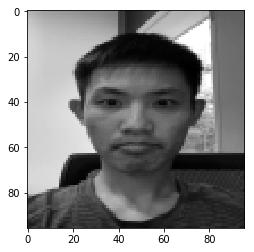

[ 0.7019608   0.6901961   0.67843139 ...,  0.14901961  0.10980392
  0.1254902 ]
(1, 9216)
[[ 0.00275279  0.00270665  0.00266052 ...,  0.00058439  0.0004306
   0.00049212]]


NameError: name 'net1' is not defined

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = cv2.imread('./wu_greyscale1.png')

print(img.shape)


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img = mpimg.imread('./wu_greyscale1.png')     
gray = rgb2gray(img)    
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

X = gray.flatten()
print(X)
y = np.expand_dims(X, axis=0)
y = y / 255.  # scale pixel values to [0, 1]
y = y.astype(np.float32)
print(y.shape)
print(y)

y_pred1 = net1.predict(y)
X2 = y.reshape(-1, 1, 96, 96)
y_pred2 = net2.predict(X2)



# print(y_pred.shape)
# print(y_pred)


# fig = plt.figure(figsize=(7, 4))
# ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
# plot_sample(sample1[0], y_pred1, ax)
# ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
# plot_sample(sample1[0], y_pred2, ax)
# plt.show()

def plot_wu(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
#     print(y[0::2] * 48 + 48)
#     print(y[0][1::2] * 48 + 48)
    
    axis.scatter(y[0][0::2] * 48 + 48, y[0][1::2] * 48 + 48, marker='*', s=20)

# fig1 = plt.figure(figsize=(7, 7),gray, y_pred2)
# plot_wu(gray, y_pred2, ax)





# ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
# plot_wu(gray, y_pred1, ax)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_wu(gray, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_wu(gray, y_pred2, ax)
plt.show()

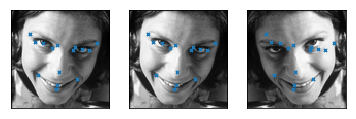

In [8]:
import matplotlib.pyplot as plt

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)


X, y = load2d()

X_flipped = X[:, :, :, ::-1]  # simple slice to flip all images

# plot two images:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
plot_sample(X[1],y[1], ax)
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
plt.show()

In [9]:
y[0]

array([ 0.38161111, -0.21757638, -0.40208334, -0.21338195,  0.21397223,
       -0.20919445,  0.56600696, -0.21338195, -0.20930555, -0.2008125 ,
       -0.5739097 , -0.18404861,  0.16787501, -0.37682638,  0.6707778 ,
       -0.33072916, -0.16739583, -0.37263888, -0.70382637, -0.23852777,
        0.03376389,  0.22246528,  0.41932639,  0.51163888, -0.38531944,
        0.5158264 ,  0.02538195,  0.44038889,  0.03376389,  0.8259514 ], dtype=float32)

In [10]:
X[1]
X.shape
X_flipped = X[:, :, :, ::-1]
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df1 = read_csv(os.path.expanduser(FTRAIN))
X1, y1 = load2d()

print(y1[0])

[ 0.38161111 -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.16787501 -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.37263888
 -0.70382637 -0.23852777  0.03376389  0.22246528  0.41932639  0.51163888
 -0.38531944  0.5158264   0.02538195  0.44038889  0.03376389  0.8259514 ]


[-0.40208334 -0.21338195  0.38161111 -0.21757638 -0.20930555 -0.2008125
 -0.5739097  -0.18404861  0.21397223 -0.20919445  0.56600696 -0.21338195
 -0.16739583 -0.37263888 -0.70382637 -0.23852777  0.16787501 -0.37682638
  0.6707778  -0.33072916  0.03376389  0.22246528 -0.38531944  0.5158264
  0.41932639  0.51163888  0.02538195  0.44038889  0.03376389  0.8259514 ]
[ 0.38161111 -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.16787501 -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.37263888
 -0.70382637 -0.23852777  0.03376389  0.22246528  0.41932639  0.51163888
 -0.38531944  0.5158264   0.02538195  0.44038889  0.03376389  0.8259514 ]
[[[ 0.14117648  0.12156863  0.11372549 ...,  0.59607846  0.70588237
    0.79607844]
  [ 0.14901961  0.13333334  0.11764706 ...,  0.63921571  0.82352942
    0.81176472]
  [ 0.14117648  0.11764706  0.13333334 ...,  0.42745098  0.69803923
    0.81176472]
  ..., 
  [ 0.1411

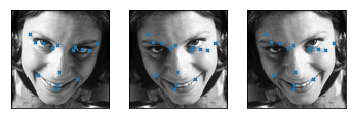

In [131]:
for i in range(0, 2140):
    for a, b in flip_indices:
        y1[i][a], y1[i][b] = (
        y1[i][b], y1[i][a])
yf=y1        
print(yf[0])
print(y[0])


def plot_flip(x,y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

print(X_flipped[0])
fig1 = plt.figure(figsize=(6, 3))
ax = fig1.add_subplot(1, 3, 1, xticks=[], yticks=[])
plot_sample(X[1],y[1], ax)
ax = fig1.add_subplot(1, 3, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1],yf[1], ax)
fig2 = plt.figure(figsize=(6, 3))
ax = fig1.add_subplot(1, 3, 3, xticks=[], yticks=[])

# plot_flip(y1[1], ax)
plot_flip(X_flipped[1],yf[1], ax)

plt.show()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


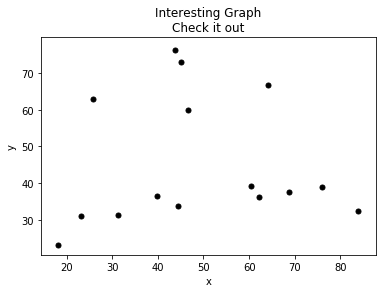

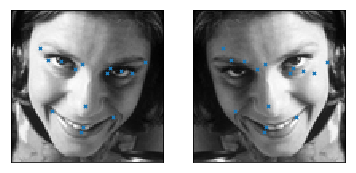

In [119]:
num_list = list(range(0, 30))
 
odd_nums = []
even_nums = []
 
for x in num_list:    
    if x % 2 == 0:        
        even_nums.append(x)
    else:       
        odd_nums.append(x)
print(even_nums)

print(odd_nums)

for i in even_nums:
    plt.scatter(y1[1][i]* 48 + 48,y1[1][i+1]* 48 + 48, color='k', s=25, marker="o")
    

# for i in even_nums:
#     plt.scatter(y1[1][i]* 48 + 48,y1[1][i+1]* 48 + 48, color='k', s=25, marker="o")
    



plt.xlabel('x')
plt.ylabel('y')
plt.title('Interesting Graph\nCheck it out')
plt.legend()
plt.show()
fig1 = plt.figure(figsize=(6, 3))
ax = fig1.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1],y[1], ax)
ax = fig1.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1],y1[1], ax)
fig2 = plt.figure(figsize=(6, 3))
ax = fig1.add_subplot(xticks=[], yticks=[])

plt.show()

In [68]:
for i in range(0, 4):
    print(i)

0
1
2
3


In [11]:
print(y1[0])
print(y[0])
print(y1.shape)
print(y.shape)

[ 0.38161111 -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.16787501 -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.37263888
 -0.70382637 -0.23852777  0.03376389  0.22246528  0.41932639  0.51163888
 -0.38531944  0.5158264   0.02538195  0.44038889  0.03376389  0.8259514 ]
[ 0.38161111 -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.16787501 -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.37263888
 -0.70382637 -0.23852777  0.03376389  0.22246528  0.41932639  0.51163888
 -0.38531944  0.5158264   0.02538195  0.44038889  0.03376389  0.8259514 ]
(2140, 30)
(2140, 30)


In [12]:
import pandas as pd 
d = {'colums1': [y],
     'colums2': [y1],
     'Image': [X], 
     'Image2': [X_flipped]}

df2 = pd.DataFrame(d)

print(df2.head)

<bound method NDFrame.head of                                                Image  \
0  [[[[ 0.79607844  0.70588237  0.59607846  0.533...   

                                              Image2  \
0  [[[[ 0.14117648  0.12156863  0.11372549  0.117...   

                                             colums1  \
0  [[0.381611, -0.217576, -0.402083, -0.213382, 0...   

                                             colums2  
0  [[0.381611, -0.217576, -0.402083, -0.213382, 0...  >


In [155]:
print(df2.loc[0].head)

<bound method NDFrame.head of Image      [[[[ 0.79607844  0.70588237  0.59607846  0.533...
Image2     [[[[ 0.14117648  0.12156863  0.11372549  0.117...
colums1    [[-0.402083, -0.213382, 0.381611, -0.217576, -...
colums2    [[-0.402083, -0.213382, 0.381611, -0.217576, -...
Name: 0, dtype: object>


In [13]:
print(df2.loc[0]['Image'][1])
print(df2.loc[0]['Image'][1].shape)
print(df2.loc[0]['Image2'][1])
print(df2.loc[0]['Image2'][1].shape)
# X_flipped = X[:, :, :, ::-1]
print(df2.loc[0]['Image2'][1][:, :, ::-1])
print(df2.loc[0]['Image2'][1].shape)

[[[ 0.12941177  0.21960784  0.34509805 ...,  0.0627451   0.0627451
    0.07058824]
  [ 0.11764706  0.25882354  0.33725491 ...,  0.10196079  0.0627451
    0.05490196]
  [ 0.17647059  0.29019609  0.26666668 ...,  0.10588235  0.09019608
    0.05098039]
  ..., 
  [ 0.49019608  0.60392159  0.71372551 ...,  0.1254902   0.12156863
    0.11372549]
  [ 0.50980395  0.59607846  0.72941178 ...,  0.16470589  0.15294118
    0.14509805]
  [ 0.53725493  0.67450982  0.76862746 ...,  0.21176471  0.22352941
    0.23137255]]]
(1, 96, 96)
[[[ 0.07058824  0.0627451   0.0627451  ...,  0.34509805  0.21960784
    0.12941177]
  [ 0.05490196  0.0627451   0.10196079 ...,  0.33725491  0.25882354
    0.11764706]
  [ 0.05098039  0.09019608  0.10588235 ...,  0.26666668  0.29019609
    0.17647059]
  ..., 
  [ 0.11372549  0.12156863  0.1254902  ...,  0.71372551  0.60392159
    0.49019608]
  [ 0.14509805  0.15294118  0.16470589 ...,  0.72941178  0.59607846
    0.50980395]
  [ 0.23137255  0.22352941  0.21176471 ...,  0.7

In [14]:
# df2.to_csv(r'./fliped_with_drop_old_2140.csv', header=None, index=None, sep=' ', mode='a')
df2.to_csv(r'./fliped_with_drop_old_2140_2.csv', sep='\t',index=False, encoding='utf-8')

In [39]:
# df3 = read_csv(os.path.expanduser(r'./fliped_with_drop_old_2140.csv')  # load pandas dataframe
# df3 = pd.read_csv('fliped_with_drop_old_2140_2.csv')
df3 = pd.read_csv('fliped_with_drop_old_2140.txt')

In [41]:
df3.head

<bound method NDFrame.head of     [[[[ 0.79607844  0.70588237  0.59607846 ...,  0.11372549  0.12156863\n     0.14117648]\n   [ 0.81176472  0.82352942  0.63921571 ...,  0.11764706  0.13333334\n     0.14901961]\n   [ 0.81176472  0.69803923  0.42745098 ...,  0.13333334  0.11764706\n     0.14117648]\n   ..., \n   [ 0.10980392  0.10588235  0.10196079 ...,  0.12156863  0.11764706\n     0.14117648]\n   [ 0.10980392  0.10980392  0.10588235 ...,  0.11764706  0.13333334\n     0.15686275]\n   [ 0.12156863  0.11764706  0.11372549 ...,  0.11372549  0.14901961\n     0.17254902]]]\n\n\n [[[ 0.12941177  0.21960784  0.34509805 ...,  0.0627451   0.0627451\n     0.07058824]\n   [ 0.11764706  0.25882354  0.33725491 ...,  0.10196079  0.0627451\n     0.05490196]\n   [ 0.17647059  0.29019609  0.26666668 ...,  0.10588235  0.09019608\n     0.05098039]\n   ..., \n   [ 0.49019608  0.60392159  0.71372551 ...,  0.1254902   0.12156863\n     0.11372549]\n   [ 0.50980395  0.59607846  0.72941178 ...,  0.16470589  0.15

In [38]:
# df2.colums1[0].shape
# import numpy as np
# import pandas as pd
# labels = y1
# s = pd.Series(list(range(0, 2140)),index=X_flipped)
# s2 = pd.Series(list(range(0, 2140)),index=labels)


# df = pd.DataFrame({'colums1':s2, 'Image':s})

In [16]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))

for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [83]:
print(df.columns[:])
print(df.index)
# print(df.dtypes)
print(df.shape)
print(df.columns[1][:][:])
df['left_eye_center_x']
# df['Image']

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
RangeIndex(start=0, stop=7049, step=1)
(7049, 31)
left_eye_center_y


0       66.033564
1       64.332936
2       65.057053
3       65.225739
4       66.725301
5       69.680748
6       64.131866
7       67.468893
8       65.802880
9       64.121231
10      65.230189
11      66.737600
12      66.574737
13      65.270588
14      66.607158
15      68.491294
16      66.676941
17      66.850428
18      67.839508
19      69.233455
20      65.595600
21      64.762466
22      66.082737
23      64.718582
24      66.334316
25      64.553043
26      65.318400
27      65.459410
28      65.376914
29      72.353185
          ...    
7019    65.608426
7020    61.997236
7021    64.906070
7022    67.045141
7023    60.202057
7024    72.226237
7025    67.724141
7026    63.013300
7027    67.277867
7028    65.840046
7029    69.463223
7030    64.392940
7031    67.367709
7032    68.320900
7033    66.162021
7034    66.651927
7035    70.504914
7036    71.258174
7037    69.616217
7038    64.615524
7039    69.229935
7040    63.352951
7041    65.711151
7042    67.929319
7043    66

In [ ]:
from nolearn.lasagne import BatchIterator

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

In [ ]:
X, y = load2d()
X_flipped = X[:, :, :, ::-1]

base_filename = 'new_data_with_flip.txt'
with open(os.path.join(WorkingFolder, base_filename),'w') as outfile:
    pd.to_string(outfile)